In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.io import ascii
from astropy import constants as const

# some kind of reading in will occur here
# for now i think i might just use some wikipedia stats...
# or wait until shane gets back to me with his data for me to read from

#amcvn_binaryDATfile.dat
filename = open('binary.dat','r')
dummy = pd.read_csv('binary.dat', delim_whitespace=False, comment='#', header=None)
print(dummy)

# the new commands were being super finicky so im doing this college python course style
# super not optomized! but i can get to that later once i know stuff works

datalist = []
amcvn = filename.readlines()
amcvn
for item in amcvn:
    equals = item.index('=')
    datalist.append(item[equals+2:-1])
datalist

                               0
0   basename  = naomiTest_1orbit
1             a (AU)    = 0.0010
2               ecc       = 0.75
3                inc (deg) = 0.0
4                m1 (msun) = 0.5
5                m2 (msun) = 0.5
6           R (pc)    = 1.000000
7                thN (deg) = 0.0
8                thP (deg) = 0.0
9                phi (deg) = 0.0
10            th1 (deg) = 0.0000
11  tsim (yr) = 3.16875357869e-5
12              Npts      = 1024
13                 fftFlag   = 1


['naomiTest_1orbit',
 '0.0010',
 '0.75',
 '0.0',
 '0.5',
 '0.5',
 '1.000000',
 '0.0',
 '0.0',
 '0.0',
 '0.0000',
 '3.16875357869e-5',
 '1024',
 '1']

In [51]:
# initial condition

datalist[11] = 6.16 * (10**-5)
print(datalist)

#masses, switching to SI units aka kg
mass1 = eval(datalist[4])
mass2 = eval(datalist[5])
solarmass = 1.989 * (10**30)
mass1 = mass1 * solarmass
mass2 = mass2 * solarmass
print(mass1)
print(mass2)

#semi-major axis
smajaxis = eval(datalist[1])
aumeter = 1.496 * (10**11)
smajaxis = smajaxis * aumeter
print(smajaxis)

#eccentricity 
ecc = eval(datalist[2])
print(ecc)

#orbital period
g = const.G.value # already in SI
print(g)
initnumer = 4 * (np.pi**2) * (smajaxis**3)
initdenom = (mass1 + mass2) * g
P = np.sqrt(initnumer/initdenom)
print(P)

#rp, for later
rp = smajaxis * (1-ecc)
print(rp)


['naomiTest_1orbit', '0.0010', '0.75', '0.0', '0.5', '0.5', '1.000000', '0.0', '0.0', '0.0', '0.0000', 6.16e-05, '1024', '1']
9.945000000000001e+29
9.945000000000001e+29
149600000.0
0.75
6.6743e-11
997.8310299904202
37400000.0


In [90]:
# the low and high can be found in the file
# can steps be found in the file?
# used variables so i can always edit my times array

low = 0
high = 1000 #I NEED AN EQUATION FOR THIS
print(high)
step = eval(datalist[12])
timeindex = np.linspace(low,high,step)
#dt = datalist[11] / step
dt = timeindex[1] - timeindex[0]
print(step)
print(len(timeindex))
print(timeindex)
print(dt)

1000
1024
1024
[0.00000000e+00 9.77517107e-01 1.95503421e+00 ... 9.98044966e+02
 9.99022483e+02 1.00000000e+03]
0.9775171065493646


In [49]:
def keqn(manomaly,psi):
    kep = psi- (ecc*np.sin(psi)) - manomaly
    return kep

In [71]:
#bisection function
#calc khigh and klow and make sure they're different signs, set tolerance
#we need some sort of loop to keep trying until knew > tolerance
#that will let the function keep doing its thing without infinite recursion 
#sounds like a for loop, not sure what range... lets make that a variable i can change for simplicity
#and knew < tolerance would result in a break
#on each iteration i get my psinew, knew, then check the sign 
#subsequently, reassign psilow and psihigh
#at the end return psiroot

#def bisec(psihigh,psilow,bimanom):
    #khigh = keqn(bimanom,psihigh)
    #klow = keqn(bimanom,psilow)
    #tolerance = 0.00001
    
    #psinew = psilow + (0.5*(psihigh-psilow))
    #knew = keqn(bimanom,psinew)
    
    #if np.sign(klow) == np.sign(khigh):
        #string = "No Root Possible!"
        #return string
    
    #if knew < tolerance:
        #print(psinew)
        #return psinew
    
    #while knew >= tolerance:
        #psinew = psilow + (0.5*(psihigh-psilow))
        #knew = keqn(bimanom,psinew)
        #if np.sign(knew) > 0:
            #psihigh = psinew
            #print("moving down")
            #bisec(psihigh,psilow,bimanom)
        #elif np.sign(knew) < 0:
            #psilow = psinew
            #print("moving up")
            #bisec(psihigh,psilow,bimanom)
            
            
# THIS IS WAY TOO MESSY 
# I NEED TO WRITE THIS MORE SIMPLY SO I CAN SEE WHERE THE ISSUE IS

In [93]:
def bisec(psihigh,psilow,bimanom):
    
    khigh = keqn(bimanom,psihigh)
    klow = keqn(bimanom,psilow)
    tolerance = 0.00001
    
    psinew = psilow + (0.5*(psihigh-psilow))
    knew = keqn(bimanom,psinew)
    
    if np.sign(klow) == np.sign(khigh):
        #print(psilow)
        #print(psihigh)
        string = "No Root Possible!"
        return string
    
    while(abs(knew) >= tolerance):
        if np.sign(knew) > 0:
            psihigh = psinew
            #print('down')
        elif np.sign(knew) < 0:
            psilow = psinew
            #print('up')
        psinew = psilow + (0.5*(psihigh-psilow))
        knew = keqn(bimanom,psinew)
    
    if knew < tolerance:
        return psinew

In [7]:
def shapeq(rp,theta):
    r = (rp*(1+ecc)) / (1 + ecc*np.cos(theta))
    return r

In [96]:
# create list that will hold my thetas for each time, maybe by r values too
thetalist = []
rlist = []
xlist = []
ylist = []
currentime = 0
psihi = 1
psilo = 0
deltapsi = 1


for loop in range(step): #for every single time
    #don't think i need to reset a currentime variable
    #if my t inherently goes for the number of steps i have, increasing by dt each time
    #determined dt above
    manom = ((2*np.pi)/P)*currentime
     
    # i define my bracket somewhere here
    psihi = 70
    psilo = 0
    psirt = bisec(psihi,psilo,manom)
    numer = 1+ecc
    denom = 1-ecc
    squareroot = np.sqrt(numer/denom)
    theta = 2*(np.arctan(squareroot*np.tan(psirt/2))) #+ (loop*np.pi)
    #theta = (theta * 180) / np.pi #putiting into degrees for SI

    #adding to my lists
    thetalist.append(theta)
    rlist.append(shapeq(rp,thetalist[loop]))
    xlist.append(rlist[loop] * np.cos(theta))
    ylist.append(rlist[loop] * np.sin(theta))
    
    #psilo = psirt
    #psihi = psilo + deltapsi
    currentime = currentime + dt
    
# some checks on numbers
#print(squareroot)
#print(psirt)
#print(thetalist)
print(currentime)

1000.9775171065643


In [9]:
#print(rlist)
# issue: rlist prints unique numbers up until certain index then they seem to be duplicates
# this therefore carries over to xlist and ylist

<IPython.core.display.Javascript object>


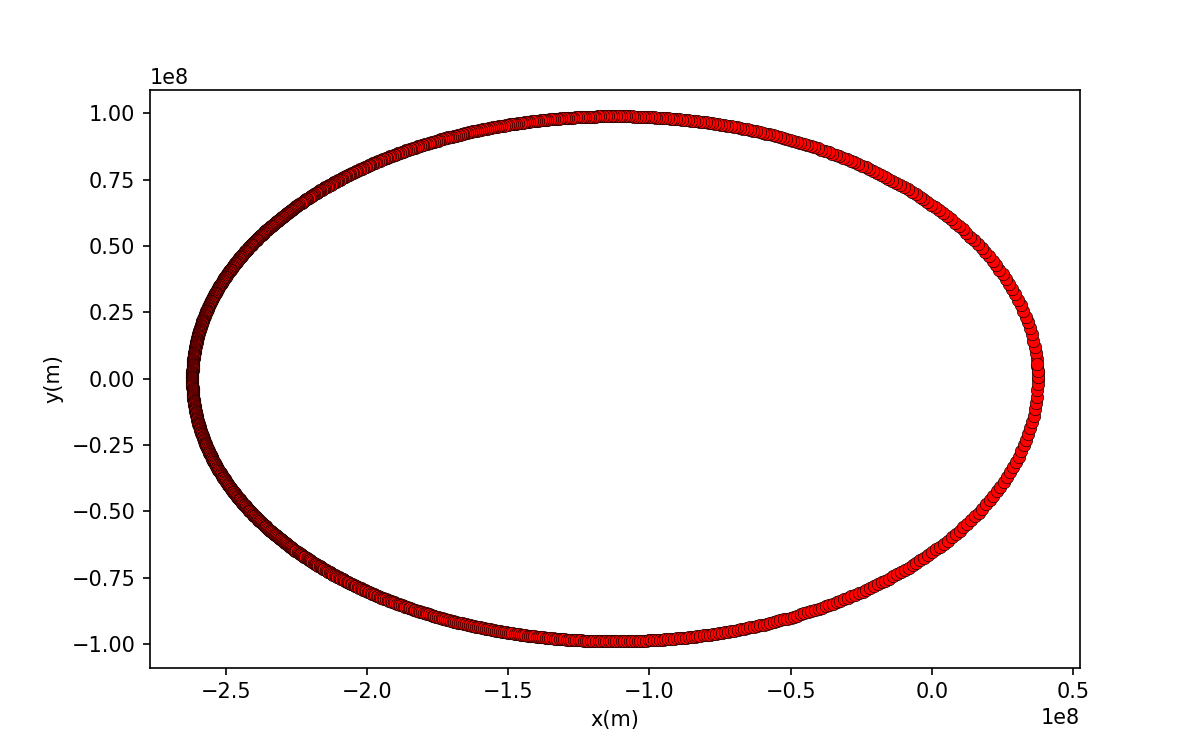

Text(0, 0.5, 'y(m)')

In [98]:
#plotting my orbit
f,ax = plt.subplots(figsize=(8,5))
ax.scatter(xlist,ylist, c='red', linewidths=0.3, edgecolors='k')
ax.set_xlabel("x(m)")
ax.set_ylabel("y(m)")
#ax.set_aspect('equal') #command for to check if it looks right / equal aspect ratio
#ax.set_xlim(-3*(10**8),5*(10**7))
#ax.set_ylim(-3*(10**8),5*(10**8))